In [1]:

import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from lifelines import KaplanMeierFitter


from itertools import cycle


failure_data = pd.read_csv(r'Failure_modelling\Failure_Data\failure_data.csv', index_col=0)
pipe_data = pd.read_csv(r'Failure_modelling\Failure_Data\pipe_data.csv', index_col=0)

Text(0, 0.5, 'Mean length of pipe per material [m]')

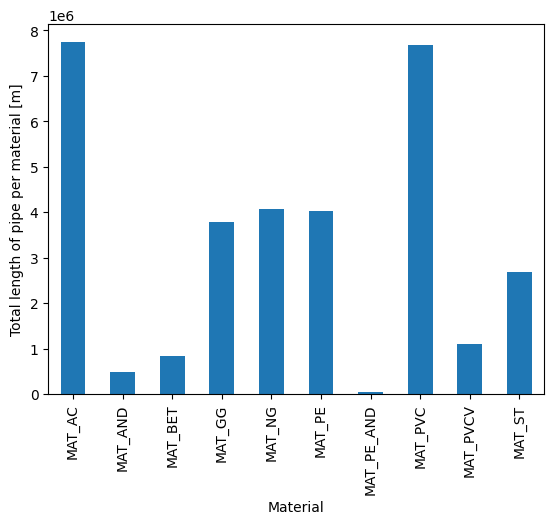

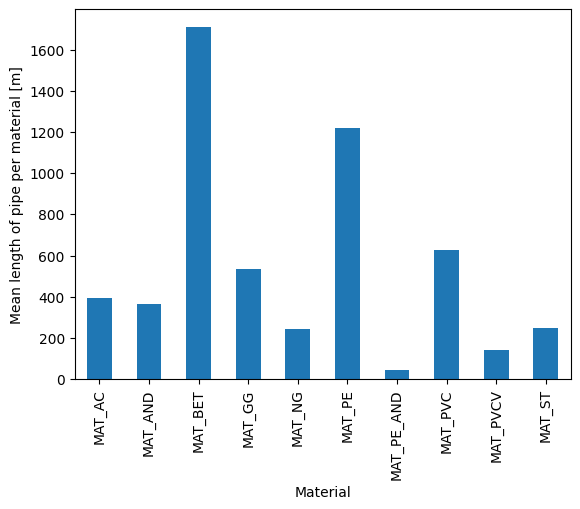

In [2]:
pipe_data['Lengte'].groupby(pipe_data['Materiaalcode']).sum().plot(kind='bar')
plt.xlabel('Material')
plt.ylabel('Total length of pipe per material [m]')
plt.figure()
pipe_data['Lengte'].groupby(pipe_data['Materiaalcode']).mean().plot(kind='bar')
plt.xlabel('Material')
plt.ylabel('Mean length of pipe per material [m]')

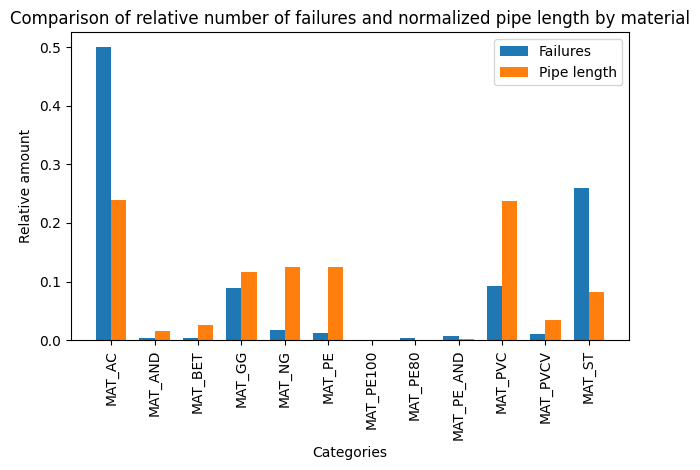

In [3]:
import matplotlib.pyplot as plt

failure_counts = failure_data['storing_materiaal'].value_counts(normalize=True)
pipe_counts = pipe_data.groupby('Materiaalcode')['Lengte'].sum()

# Convert indices to strings
failure_counts.index = failure_counts.index.astype(str)
pipe_counts.index = pipe_counts.index.astype(str)

# Merge indices and sort them
categories = sorted(set(failure_counts.index) | set(pipe_counts.index))

# Normalize pipe_counts
pipe_counts_normalized = pipe_counts / pipe_counts.sum()

failure_counts = failure_counts.reindex(categories, fill_value=0)
pipe_counts_normalized = pipe_counts_normalized.reindex(categories, fill_value=0)

width = 0.35 
x = range(len(categories))  

plt.bar(x, failure_counts, width, label='Failures')
plt.bar([i + width for i in x], pipe_counts_normalized, width, label='Pipe length')

plt.xlabel('Categories')
plt.ylabel('Relative amount')
plt.title('Comparison of relative number of failures and normalized pipe length by material')
plt.xticks([i + width/2 for i in x], categories, rotation='vertical')
plt.legend()

plt.tight_layout()
plt.show()


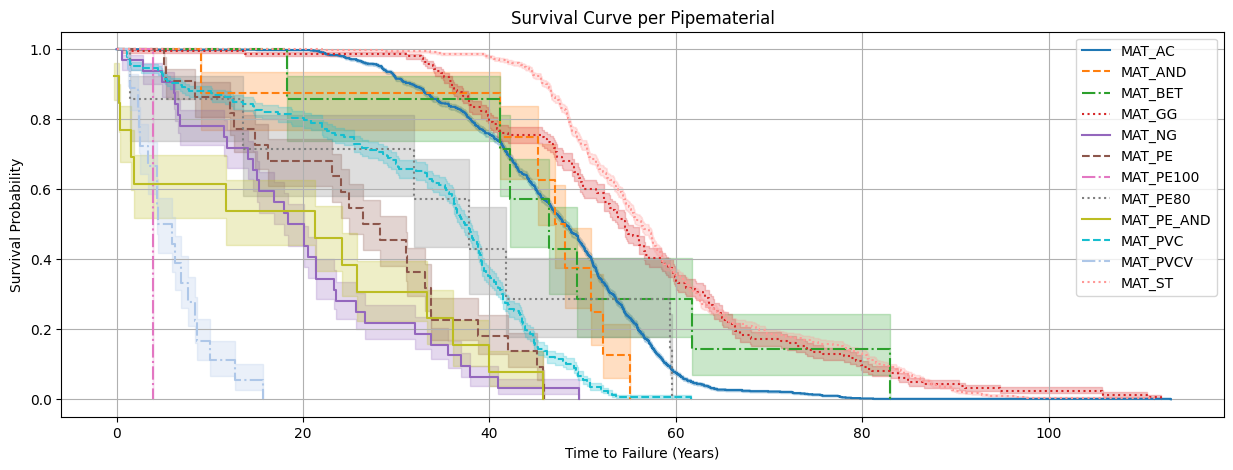

In [4]:
kmf = KaplanMeierFitter()

# Define colors and line styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#aec7e8', '#ff9896', '#ffbb78', '#98df8a', '#ff9896',
          '#9edae5', '#c5b0d5']
line_styles = ['-', '--', '-.', ':']

# Create a cycle iterator for both colors and line styles
color_cycle = cycle(colors)
line_style_cycle = cycle(line_styles)
plt.figure(figsize=(15,5))
for i, (material, group) in enumerate(failure_data.groupby('storing_materiaal')):
    kmf.fit(group['age_at_failure'], event_observed=(group['storing_melddatum'].notnull()), label=material, alpha=0.5)
    color = next(color_cycle)
    line_style = next(line_style_cycle)
    kmf.plot(color=color, linestyle=line_style, label=material)
plt.title('Survival Curve per Pipematerial')
plt.xlabel('Time to Failure (Years)')
plt.ylabel('Survival Probability')
plt.grid()
plt.show()

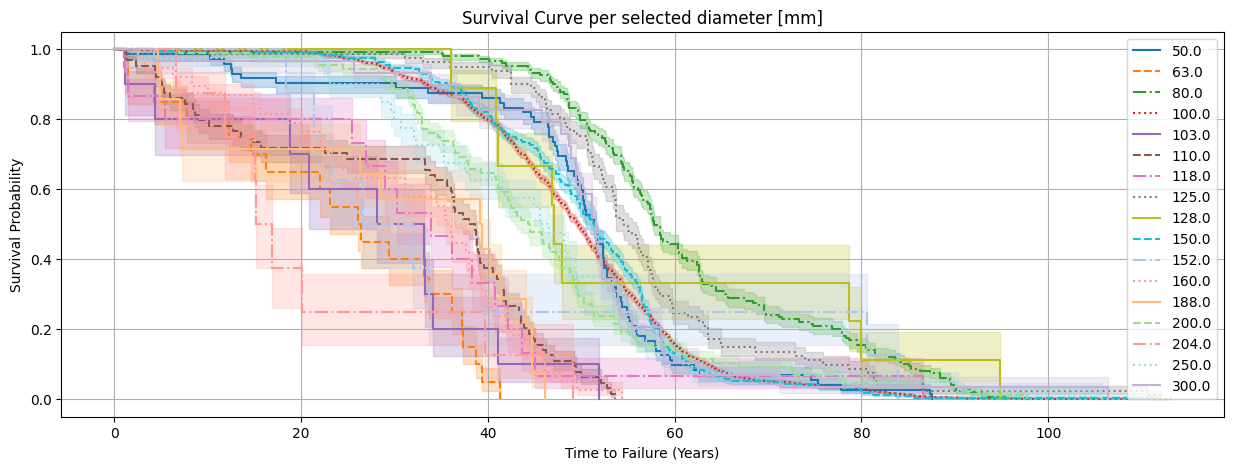

In [5]:
failure_data_filtered = failure_data.groupby('storing_diameter').filter(lambda x: len(x) >= 8)
kmf = KaplanMeierFitter()


# Define colors and line styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#aec7e8', '#ff9896', '#ffbb78', '#98df8a', '#ff9896',
          '#9edae5', '#c5b0d5']
line_styles = ['-', '--', '-.', ':']

# Create a cycle iterator for both colors and line styles
color_cycle = cycle(colors)
line_style_cycle = cycle(line_styles)

plt.figure(figsize=(15, 5))
for i, (material, group) in enumerate(failure_data_filtered.groupby('storing_diameter')):
    kmf.fit(group['age_at_failure'], event_observed=(group['storing_melddatum'].notnull()), label=material, alpha=0.5)
    color = next(color_cycle)
    line_style = next(line_style_cycle)
    kmf.plot(color=color, linestyle=line_style, label=material)

plt.title('Survival Curve per selected diameter [mm]')
plt.xlabel('Time to Failure (Years)')
plt.ylabel('Survival Probability')
plt.grid()
plt.show()

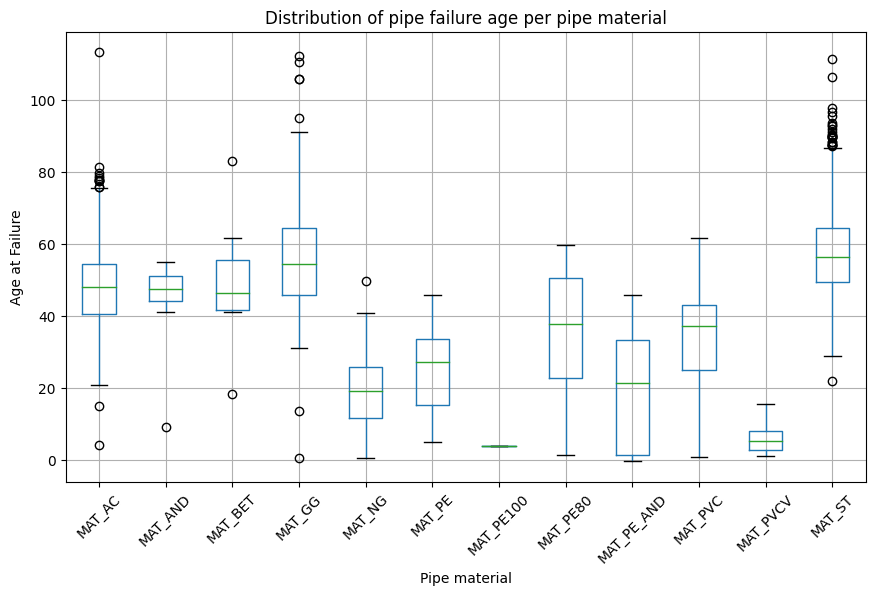

In [6]:
boxplot = failure_data.boxplot(column='age_at_failure', by='storing_materiaal', figsize=(10, 6))
plt.xlabel('Pipe material')
plt.ylabel('Age at Failure')
plt.suptitle('')
plt.title('Distribution of pipe failure age per pipe material')

boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)

plt.show()

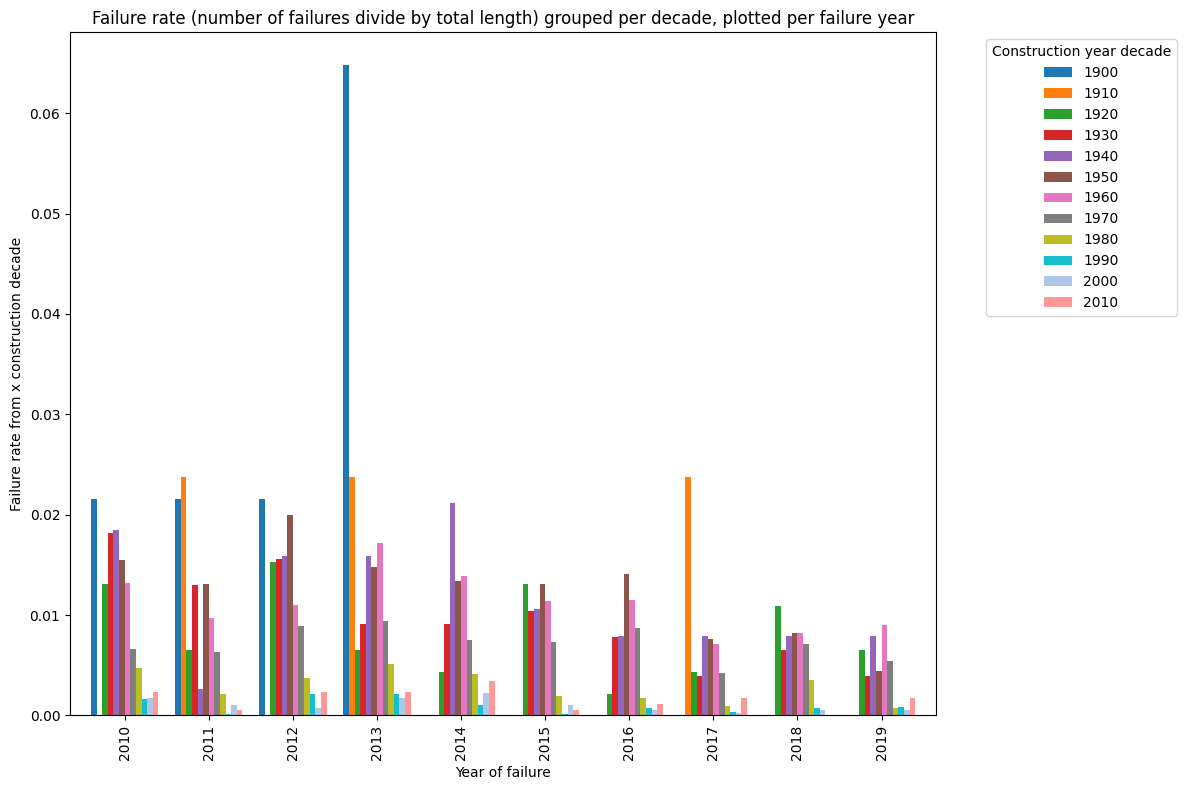

In [7]:
# Convert 'storing_melddatum' to datetime
failure_data['storing_melddatum'] = pd.to_datetime(failure_data['storing_melddatum'])

# Extract year from 'storing_melddatum'
failure_data['year'] = failure_data['storing_melddatum'].dt.year

# Group by 'year' and 'storing_aanlegjaar' and count the occurrences
grouped_data = failure_data.groupby(['year', 'storing_aanlegjaar']).size().unstack(fill_value=0)

# Group storing_aanlegjaar per 10 years
grouped_data_columns = pd.to_datetime(grouped_data.columns).year
grouped_data_columns = ((grouped_data_columns - grouped_data_columns.min()) // 10) * 10 + grouped_data_columns.min()
grouped_data = grouped_data.groupby(grouped_data_columns, axis=1).sum()

pipe_data['Decade'] = (pipe_data['Aanlegjaar'] // 10) * 10
length_per_decade = pipe_data.groupby('Decade')['Lengte'].sum().reset_index()
length_per_decade = length_per_decade[length_per_decade.Decade >= 1900]

length_per_decade.Lengte = length_per_decade.Lengte / 1000

# Normalize the data by the length per decade
for i, row in grouped_data.iterrows():
    grouped_data.loc[i] = (row.values / length_per_decade.Lengte.values)

# Plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ff9896']
ax = grouped_data.plot(kind='bar', figsize=(12, 8), color=colors, width=0.8)

# Adjusting the x-axis and legend
plt.xlabel('Year of failure')
plt.ylabel('Failure rate from x construction decade')
plt.title('Failure rate (number of failures divide by total length) grouped per decade, plotted per failure year')
plt.legend(title='Construction year decade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()


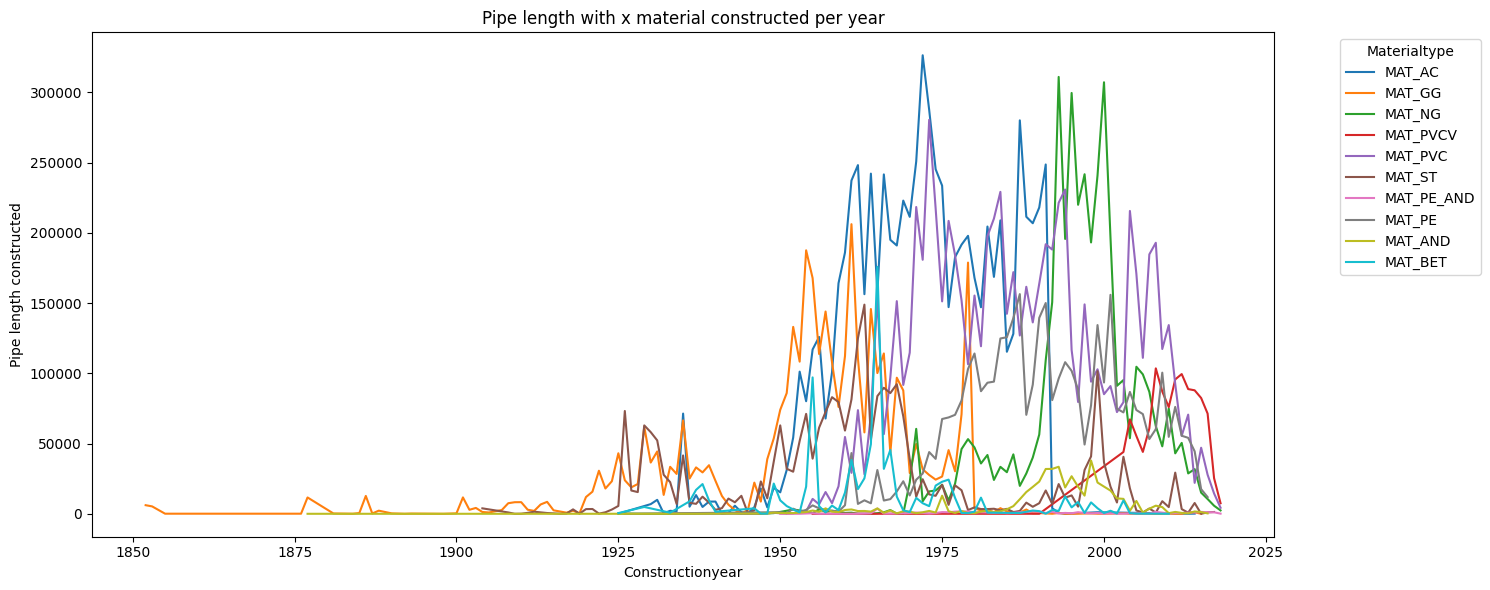

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pipe_data is your DataFrame
unique_materiaal = pipe_data['Materiaalcode'].unique().tolist()

plt.figure(figsize=(15, 6))

# Filter out rows with 'Aanlegjaar' less than 1
filtered_pipe_data = pipe_data[pipe_data['Aanlegjaar'] > 1]

# Iterate over unique 'Materiaalcode' values and plot the corresponding data
for materiaal in unique_materiaal:
    materiaal_data = filtered_pipe_data[filtered_pipe_data['Materiaalcode'] == materiaal].groupby('Aanlegjaar')['Lengte'].sum()
    plt.plot(materiaal_data.index, materiaal_data, label=materiaal)

plt.xlabel('Constructionyear')
plt.ylabel('Pipe length constructed')
plt.title('Pipe length with x material constructed per year')
plt.legend(title='Materialtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


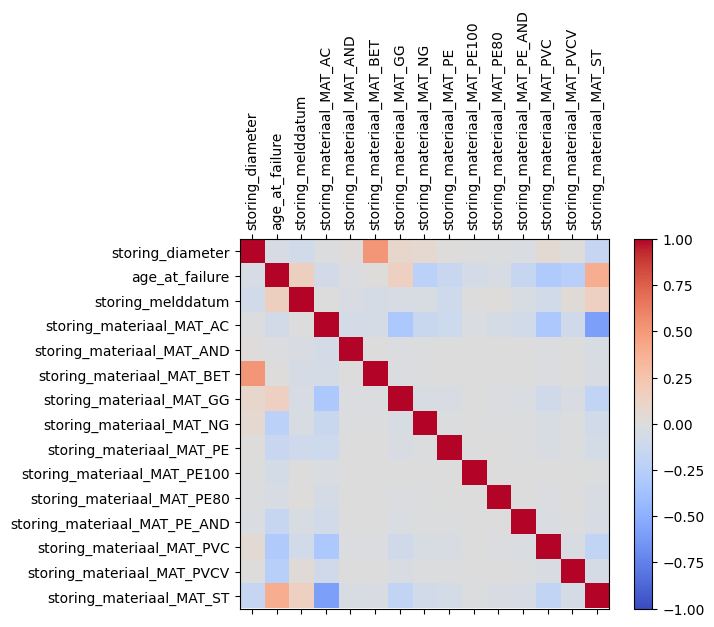

In [9]:
failure_data_selected = failure_data[['storing_diameter', 'storing_melddatum', 'storing_materiaal', 'age_at_failure']].copy()
numeric_columns = failure_data_selected.select_dtypes(include='number')

# 2. Encode non-numeric columns into dummy variables
non_numeric_columns = failure_data_selected.select_dtypes(exclude='number')
dummy_variables = pd.get_dummies(non_numeric_columns)

# 3. Concatenate numeric columns and dummy variables
combined_data = pd.concat([numeric_columns, dummy_variables], axis=1)

# 4. Calculate the correlation matrix
corr = combined_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(combined_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(combined_data.columns)
ax.set_yticklabels(combined_data.columns)
plt.show()

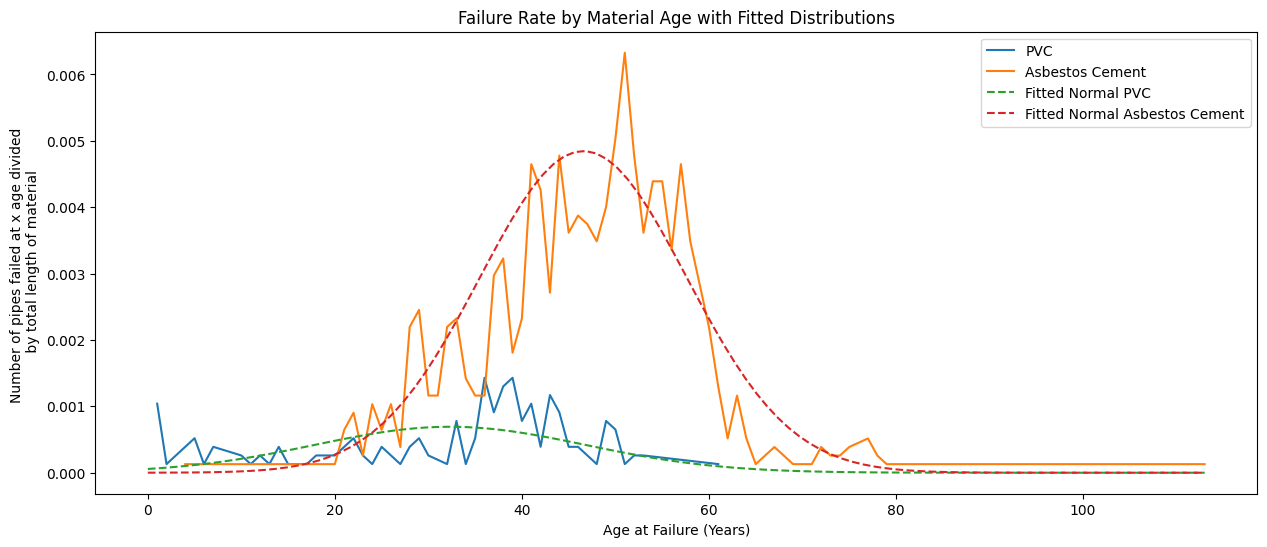

In [11]:
import seaborn as sns
from scipy.stats import gaussian_kde, norm, gumbel_r

# Assuming pipe_data and failure_data are already defined and preprocessed

len_per_mat = pipe_data['Lengte'].groupby(pipe_data['Materiaalcode']).sum() / 1000
fail_ac_pvc = failure_data[(failure_data['storing_materiaal'] == 'MAT_AC') | (failure_data['storing_materiaal'] == 'MAT_PVC')].copy()
fail_ac_pvc['age_int'] = fail_ac_pvc['age_at_failure'].astype(int)

# Calculate failure rates
pvc_failures = fail_ac_pvc[fail_ac_pvc['storing_materiaal'] == 'MAT_PVC']
ac_failures = fail_ac_pvc[fail_ac_pvc['storing_materiaal'] == 'MAT_AC']
pvc_failure_rate = pvc_failures['year'].groupby(pvc_failures['age_int']).count() / len_per_mat['MAT_PVC']
ac_failure_rate = ac_failures['year'].groupby(ac_failures['age_int']).count() / len_per_mat['MAT_AC']

# Fit a normal distribution to the age at failure
pvc_fit_params = norm.fit(pvc_failures['age_int'])
ac_fit_params = norm.fit(ac_failures['age_int'])

# Generate a range of ages
ages = np.linspace(0, max(fail_ac_pvc['age_int']), 100)

# Get the PDF of the fitted distributions
pvc_pdf = norm.pdf(ages, *pvc_fit_params)
ac_pdf = norm.pdf(ages, *ac_fit_params)

# Plot the data
plt.figure(figsize=(15,6))

# Plot the failure rates
pvc_failure_rate.plot(label='PVC')
ac_failure_rate.plot(label='Asbestos Cement')

# Plot the fitted distribution
plt.plot(ages, pvc_pdf / pvc_pdf.sum() * pvc_failure_rate.sum(), label='Fitted Normal PVC', linestyle='--')
plt.plot(ages, ac_pdf / ac_pdf.sum() * ac_failure_rate.sum(), label='Fitted Normal Asbestos Cement', linestyle='--')

plt.xlabel('Age at Failure (Years)')
plt.ylabel('Number of pipes failed at x age divided \n by total length of material')
plt.legend()
plt.title('Failure Rate by Material Age with Fitted Distributions')
plt.show()
